In [ ]:
# importing the dependencies
import os
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [ ]:
# loading the dataset from kaggle server to google colab
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d jangedoo/utkface-new

Dataset URL: https://www.kaggle.com/datasets/jangedoo/utkface-new
License(s): copyright-authors
 92% 306M/331M [00:00<00:00, 884MB/s] 
100% 331M/331M [00:02<00:00, 142MB/s]


In [ ]:
# extracting the data
import zipfile
zip_ref = zipfile.ZipFile('/content/utkface-new.zip','r')
zip_ref.extractall('/content')
zip_ref.close()

In [ ]:
folder_path = '/content/utkface_aligned_cropped/UTKFace'

In [ ]:
age = []
gender = []
img_path =[]
for file in os.listdir(folder_path):
  #file_path = os.path.join(folder_path, file)
  #if os.path.isfile(file_path):
  age.append(int(file.split('_')[0]))
  gender.append(int(file.split('_')[1]))
  img_path.append(file)

In [ ]:
len(age)

23708

In [ ]:
df = pd.DataFrame({'age':age,'gender':gender,'img':img_path})

In [ ]:
df.shape

(23708, 3)

In [ ]:
df.head()

,age,gender,img
0,53,0,53_0_0_20170120223024866.jpg.chip.jpg
1,35,0,35_0_3_20170116235352900.jpg.chip.jpg
2,33,1,33_1_3_20170117174243837.jpg.chip.jpg
3,26,0,26_0_0_20170116180849908.jpg.chip.jpg
4,26,1,26_1_0_20170103235707476.jpg.chip.jpg


In [ ]:
train_df = df.sample(frac=1,random_state=0).iloc[:20000]
test_df = df.sample(frac=1,random_state=0).iloc[20000:]

In [ ]:
train_df.shape

(20000, 3)

In [ ]:
test_df.shape

(3708, 3)

In [ ]:
# data augmentation
train_datagen = ImageDataGenerator(
    rescale = 1./255,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)
test_datagen =ImageDataGenerator(
    rescale = 1./255)

In [ ]:
# generator
train_gen = train_datagen.flow_from_dataframe(
    train_df,
    directory = folder_path,
    x_col = 'img',
    y_col = ['age','gender'],
    target_size = (200,200),
    class_mode = 'raw'
)

test_gen = test_datagen.flow_from_dataframe(
    test_df,
    directory = folder_path,
    x_col = 'img',
    y_col = ['age','gender'],
    target_size = (200,200),
    class_mode = 'raw'
)

Found 20000 validated image filenames.
Found 3708 validated image filenames.


In [ ]:
# Wrap generator to split and reshape
def multi_output_generator(generator):
    for x, y in generator:
        age_labels = y[:, 0]
        gender_labels = y[:, 1].reshape(-1, 1)  # reshape to (batch, 1)
        yield x, {'age': age_labels, 'gender': gender_labels}

train_multi_gen = multi_output_generator(train_gen)
test_multi_gen = multi_output_generator(test_gen)

# Compile (you can simplify metrics too)
model.compile(
    optimizer='adam',
    loss={'age': 'mae', 'gender': 'binary_crossentropy'},
    metrics={'age': 'mae', 'gender': 'accuracy'},   # accuracy for gender, not BCE
    loss_weights={'age': 1, 'gender': 99}
)

# Fit (no need to pass batch_size again)
model.fit(train_multi_gen, epochs=10, validation_data=test_multi_gen, steps_per_epoch=len(train_gen))


Epoch 1/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 351ms/step - age_loss: 12.7240 - age_mae: 12.7240 - gender_accuracy: 0.6880 - gender_loss: 0.6531 - loss: 77.3786

In [ ]:
# Wrap generator to split 'age' and 'gender' into separate outputs
def multi_output_generator(generator):
    for x, y in generator:
        # y shape: (batch_size, 2)
        yield x, {'age': y[:, 0], 'gender': y[:, 1]}

In [ ]:
train_multi_gen = multi_output_generator(train_gen)
test_multi_gen = multi_output_generator(test_gen)


In [ ]:
from keras.applications.vgg16 import VGG16
from keras.layers import*
from keras.models import Model

In [ ]:
vggnet = VGG16(include_top=False,input_shape=(200,200,3))

In [ ]:
vggnet.trainable = False
output = vggnet.layers[-1].output
flatten = Flatten()(output)

dense1 = Dense(512,activation='relu')(flatten)
dense2 = Dense(512,activation ='relu')(flatten)

dense3 = Dense(512,activation ='relu')(dense1)
dense4 = Dense(512,activation ='relu')(dense2)

output1 = Dense(1,activation='linear',name='age')(dense3)
output2 = Dense(1,activation ='sigmoid',name='gender')(dense4)



In [ ]:
model = Model(inputs=vggnet.input,outputs=[output1,output2])

In [ ]:
model.summary()

Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_5       │ (None, 200, 200,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv1        │ (None, 200, 200,  │      1,792 │ input_layer_5[0]… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv2        │ (None, 200, 200,  │     36,928 │ block1_conv1[0][… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_pool         │ (None, 100, 100,  │          0 │ block1_conv2[0][… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_conv1        │ (None, 100, 100,  │     73,856 │ block1_pool[0][0] │
│ (Conv2D)            │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_conv2        │ (None, 100, 100,  │    147,584 │ block2_conv1[0][… │
│ (Conv2D)            │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_pool         │ (None, 50, 50,    │          0 │ block2_conv2[0][… │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block3_conv1        │ (None, 50, 50,    │    295,168 │ block2_pool[0][0] │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block3_conv2        │ (None, 50, 50,    │    590,080 │ block3_conv1[0][… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block3_conv3        │ (None, 50, 50,    │    590,080 │ block3_conv2[0][… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block3_pool         │ (None, 25, 25,    │          0 │ block3_conv3[0][… │
│ (MaxPooling2D)      │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block4_conv1        │ (None, 25, 25,    │  1,180,160 │ block3_pool[0][0] │
│ (Conv2D)            │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block4_conv2        │ (None, 25, 25,    │  2,359,808 │ block4_conv1[0][… │
│ (Conv2D)            │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block4_conv3        │ (None, 25, 25,    │  2,359,808 │ block4_conv2[0][… │
│ (Conv2D)            │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block4_pool         │ (None, 12, 12,    │          0 │ block4_conv3[0][… │
│ (MaxPooling2D)      │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block5_conv1        │ (None, 12, 12,    │  2,359,808 │ block4_pool[0][0] │
│ (Conv2D)            │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block5_conv2        │ (None, 12, 12,    │  2,359,808 │ block5_conv1[0][

 Total params: 34,116,418 (130.14 MB)

 Trainable params: 19,401,730 (74.01 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

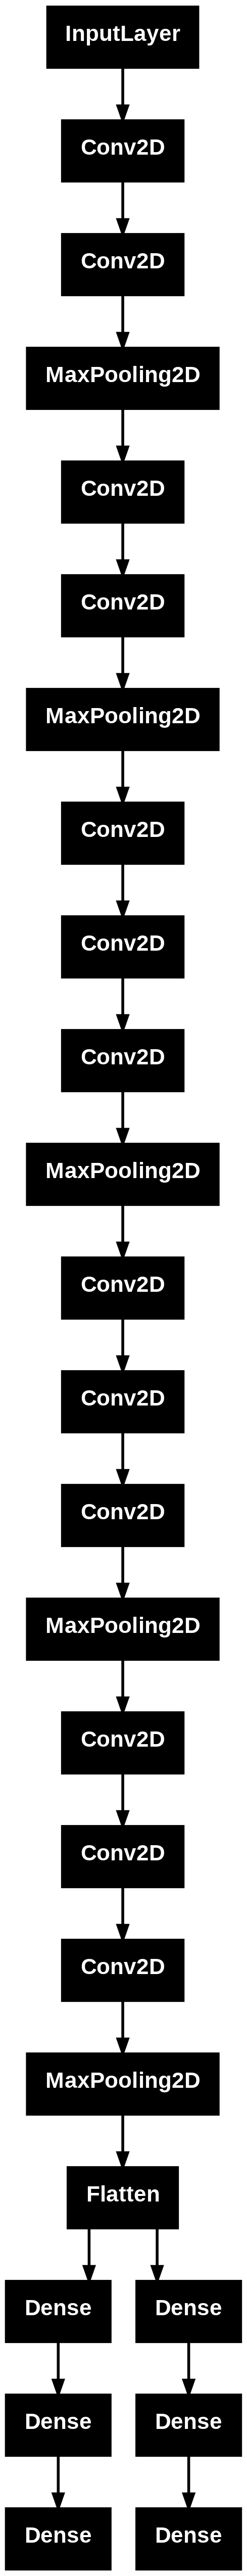

In [ ]:
from keras.utils import plot_model
plot_model(model)

In [ ]:
model.compile(
    optimizer='adam',
    loss = {'age':'mae','gender':'binary_crossentropy'},
    metrics = {'age':'mae','gender':'binary_crossentropy'},
    loss_weights = {'age':1,'gender':99}
)

In [ ]:
model.fit(train_multi_gen,batch_size=32,epochs=10,validation_data=test_multi_gen)

Epoch 1/10


ValueError: Arguments `target` and `output` must have the same rank (ndim). Received: target.shape=(None,), output.shape=(None, 1)